In [1]:
import json
import numpy as np
import pandas as pd
import cv2
import albumentations as A
from matplotlib import pyplot as plt
from albumentations.pytorch import ToTensorV2
import random

In [2]:
base_dir = "/opt/ml/segmentation/semantic-segmentation-level2-cv-11/"
data_dir = "input/data/"
json_dir = f"{base_dir}{data_dir}train_all.json"

In [3]:
with open(json_dir, "r") as json_file:
    
    data = json.load(json_file)

In [4]:
df_images = pd.DataFrame(data['images'])
df_annos = pd.DataFrame(data['annotations'])
df_categories = pd.DataFrame(data['categories'])

In [5]:
df_annos.loc[df_annos['category_id'] == 10].head(2)

,id,image_id,category_id,segmentation,area,bbox,iscrowd
173,178,28,10,"[[383, 432, 382, 432, 381, 432, 381, 431, 380,...",60925.5,"[98.9, 157.2, 342.0, 275.3]",0
316,323,47,10,"[[220, 377, 219, 377, 218, 377, 217, 377, 216,...",15961.0,"[175.7, 182.5, 118.5, 195.0]",0


In [6]:
df_images.loc[df_images['id']==28]

,license,url,file_name,height,width,date_captured,id
28,0,None,batch_01_vt/0038.jpg,512,512,None,28


In [7]:
df_new_cat = df_categories.rename(columns={'id':'category_id'})
df_new_cat

,category_id,name,supercategory
0,1,General trash,General trash
1,2,Paper,Paper
2,3,Paper pack,Paper pack
3,4,Metal,Metal
4,5,Glass,Glass
5,6,Plastic,Plastic
6,7,Styrofoam,Styrofoam
7,8,Plastic bag,Plastic bag
8,9,Battery,Battery
9,10,Clothing,Clothing


In [8]:
df_new_annos = df_annos.merge(df_new_cat, how='left', on='category_id')
df_n = df_new_annos.groupby('name').count()['id'].reset_index()
df_c = df_new_annos.groupby('name').sum()['area'].reset_index()

df_c_detail = df_n.merge(df_c, how='left', on='name')
df_c_detail = df_c_detail.rename(columns={'id':'count'})
df_c_detail['average_area'] = df_c_detail['area'] / df_c_detail['count']
df_c_detail

,name,count,area,average_area
0,Battery,63,379146.5,6018.198413
1,Clothing,177,4478693.0,25303.350282
2,General trash,2782,19384317.0,6967.763120
3,Glass,610,6816419.5,11174.458197
4,Metal,562,7830797.5,13933.803381
5,Paper,9311,79245069.0,8510.908495
6,Paper pack,659,6325877.0,9599.206373
7,Plastic,3090,24586356.0,7956.749515
8,Plastic bag,7643,101116123.5,13229.899712
9,Styrofoam,1343,13008343.0,9686.033507


<BarContainer object of 10 artists>

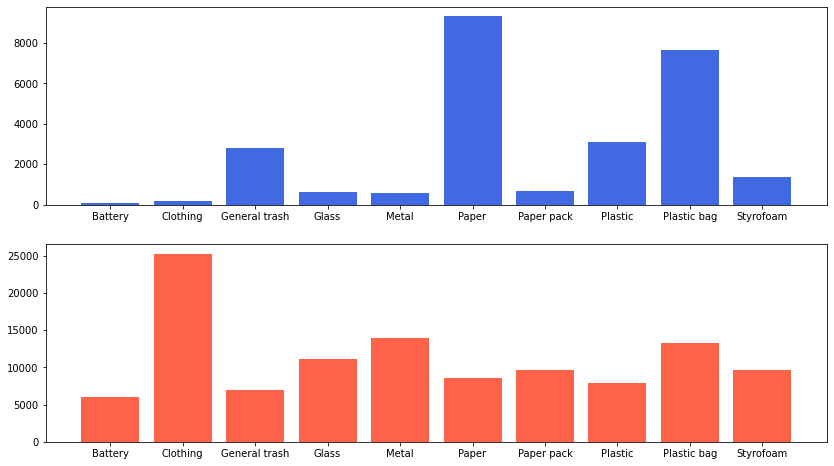

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].bar(df_c_detail['name'], df_c_detail['count'], color='royalblue')
axes[1].bar(df_c_detail['name'], df_c_detail['average_area'], color='tomato')

## Clothing

In [10]:
def show_img(idx, c_fname, bbox=None):

    plt.figure(figsize=(8,8))
    plt.axis('off')
    
    img = cv2.imread(base_dir+data_dir+c_fname[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if bbox!=None:
        x, y, w, h = bbox[idx]
        print(x, y, w, h)
        img = cv2.rectangle(img, (int(x),int(y)), (int(x+w),int(y+h)), (255, 0, 0), 3)
    plt.imshow(img)

In [11]:
df_tmp_ann = df_new_annos.loc[:,'image_id':]
df_tmp_img = df_images.rename(columns={'id':'image_id'})
df = df_tmp_img.merge(df_tmp_ann, how='left', on='image_id')

In [12]:
df_clothing = df.loc[df['name']=='Clothing']

In [13]:
df_clothing

,license,url,file_name,height,width,date_captured,image_id,category_id,segmentation,area,bbox,iscrowd,name,supercategory
173,0,None,batch_01_vt/0038.jpg,512,512,None,28,10.0,"[[383, 432, 382, 432, 381, 432, 381, 431, 380,...",60925.5,"[98.9, 157.2, 342.0, 275.3]",0.0,Clothing,Clothing
316,0,None,batch_01_vt/0059.jpg,512,512,None,47,10.0,"[[220, 377, 219, 377, 218, 377, 217, 377, 216,...",15961.0,"[175.7, 182.5, 118.5, 195.0]",0.0,Clothing,Clothing
317,0,None,batch_01_vt/0059.jpg,512,512,None,47,10.0,"[[217, 486, 216, 486, 215, 486, 214, 486, 213,...",18372.5,"[172.0, 305.0, 199.6, 181.2]",0.0,Clothing,Clothing
371,0,None,batch_01_vt/0068.jpg,512,512,None,52,10.0,"[[458, 219, 457, 219, 456, 219, 455, 219, 454,...",477.0,"[424.3, 199.9, 42.0, 20.1]",0.0,Clothing,Clothing
802,0,None,batch_01_vt/0132.jpg,512,512,None,101,10.0,"[[496, 511, 495, 511, 494, 511, 493, 511, 492,...",54877.5,"[0.0, 235.6, 505.2, 276.3]",0.0,Clothing,Clothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25814,0,None,batch_03/0907.jpg,512,512,None,3201,10.0,"[[315, 404, 314, 404, 313, 404, 312, 404, 311,...",2346.0,"[308.0, 316.2, 109.7, 89.0]",0.0,Clothing,Clothing
25815,0,None,batch_03/0907.jpg,512,512,None,3201,10.0,"[[193, 511, 192, 511, 191, 511, 190, 511, 189,...",139369.5,"[20.1, 15.6, 426.2, 496.3]",0.0,Clothing,Clothing
25946,0,None,batch_03/0938.jpg,512,512,None,3221,10.0,"[[130, 471, 129, 471, 128, 471, 127, 471, 126,...",13028.5,"[0.0, 358.8, 199.5, 112.9]",0.0,Clothing,Clothing
26121,0,None,batch_03/0978.jpg,512,512,None,3254,10.0,"[[347, 46, 346, 46, 345, 46, 345, 45, 345, 44,...",1191.0,"[303.6, 5.7, 49.6, 40.8]",0.0,Clothing,Clothing


76.7 109.5 136.8 385.0


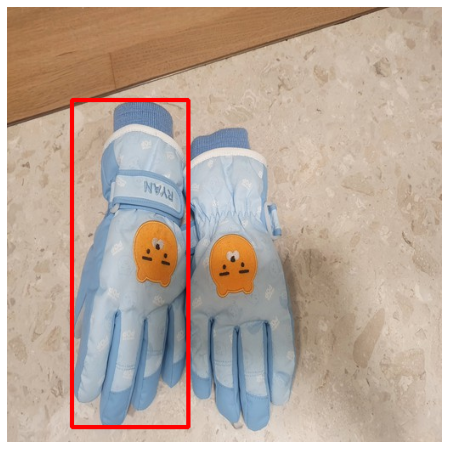

In [15]:
c_fname = list(df_clothing['file_name'])
oc_bbox = list(df_clothing['bbox'])
show_img(22, c_fname,oc_bbox)

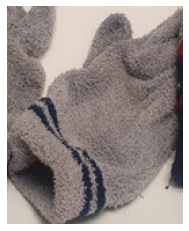

In [16]:
plt.axis('off')
idx= 17
x,y,w,h = map(int, df_clothing.iloc[idx]['bbox'])
image = cv2.imread(base_dir+data_dir+df_clothing.iloc[idx]['file_name'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[y:y+h, x:x+w]
plt.imshow(image)

In [19]:
df_nc = df_clothing.reset_index()

In [20]:
file_name = df_nc.loc[0,'file_name']

In [21]:
from pycocotools.coco import COCO

coco = COCO('/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/clothing.json')
image_id = coco.getImgIds(imgIds=0)
image_infos = coco.loadImgs(image_id)[0]

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


### Validation 결과를 통한 옷 이미지

In [24]:
def visualize(image):
    plt.axis('off')
    plt.imshow(image)

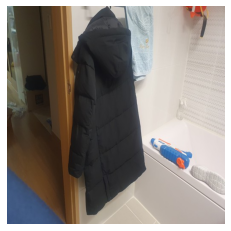

In [25]:
image = cv2.imread(base_dir+data_dir+c_fname[12])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
random.seed(10)
visualize(image)